In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import sys
import h5py
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from scipy.stats import entropy
from matplotlib import colormaps 


import utils.plotting as plotting
import utils.gen_utils as gen_utils
from tqdm import tqdm
# from configs import Configs
from utils.plotting import get_projections, MAP, offset, layer_bottom_pos, cell_thickness_global, Xmax, Xmin, Zmax, Zmin

# import k_diffusion as K

# cfg = Configs()

# print(cfg.__dict__)

/tmp/ipykernel_98538/1734686933.py:4: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


100%|██████████| 30/30 [00:00<00:00, 236.80it/s]


# Plots

In [2]:
# Define paths
# path_DA_1='CaloChallange_CD2024_04_19__14_07_37_ckpt_0.000000_800000.pt_ema_steps_32' # smeared DA 100%
path_DA_1='CaloChallange_CD2024_05_03__12_07_31_ckpt_0.000000_800000.pt_ema_steps_32' # smeared Non-DA 100%
path_DA_2='CaloChallange_CD2024_05_03__12_10_42_ckpt_0.000000_800000.pt_ema_steps_32' # DA 50%
path_DA_3='CaloChallange_CD2024_05_03__12_04_52_ckpt_0.000000_800000.pt_ema_steps_32' # Non-DA 50%

# List of paths to iterate through
path_list = [path_DA_1 ,path_DA_2, path_DA_3,]# path_DA_4]

labels = ['G4', 'DA_30 \% -lr [1-5]e-5', 'DA_15 \% -lr [1-5]e-5', 'DA_3 \% -lr [1-5]e-5',]# 'NonDA_3 \%']#, 'NonDA_10%'] 
# labels = ['G4'] + [f'DA_85\%_{i}' for i in range(1, 4)]
print(labels)

['G4', 'DA_30 \\% -lr [1-5]e-5', 'DA_15 \\% -lr [1-5]e-5', 'DA_3 \\% -lr [1-5]e-5']


In [3]:
def read_hdf5_file(file_path):
    with h5py.File(file_path, 'r') as f:
        dataset_names = list(f.keys())
        showers = f['showers'][:]
        incident = f['incident_energies'][:]
    return dataset_names, showers, incident

# list of the showers
showers = []  

# Monte Carlo shower
path_origin = '/beegfs/desy/user/valentel/CaloTransfer/data/calo-challenge/dataset_3_3_10-90GeV.hdf5'
dataset_names_origin, showers_origin, incident_energies_0 = read_hdf5_file(path_origin)

showers.append(showers_origin) 
print(f'the dataset names are: {dataset_names_origin} \n the MC shower shape is: {showers_origin.shape} \n the path is: {path_origin}')
print(f'The incident energies shape is: {incident_energies_0.shape}')

print('\n','+ - ' * 20, '\n')

prefix = '/beegfs/desy/user/valentel/CaloTransfer/calo-challenge/train-score/evaluate/outputsout/'
prefix = prefix + 'DA-train/'
subfix = 'showers.hdf5'

# Loop through the paths
for i, path in enumerate(path_list, start=1):
    path_var_name = f"path_DA_{i}"
    dataset_var_name = f"dataset_names_{i}"
    showers_var_name = f"showers_DA_{i}"  
    incident_var_name = f"incident_energies_{i}"
    path_DA_i = prefix + path + '/' + subfix
    globals()[dataset_var_name], globals()[showers_var_name], globals()[incident_var_name] = read_hdf5_file(path_DA_i)
    showers.append(globals()[showers_var_name])  
    print(f'Dataset {i}: {globals()[dataset_var_name]}\n The shower shape is: {globals()[showers_var_name].shape}\n the incident energies is: {globals()[incident_var_name].shape }\nThe path is: {path_DA_i}')
    print('\n', '+ - ' * 20, '\n'*2)

the dataset names are: ['incident_energies', 'showers'] 
 the MC shower shape is: (15921, 40500) 
 the path is: /beegfs/desy/user/valentel/CaloTransfer/data/calo-challenge/dataset_3_3_10-90GeV.hdf5
The incident energies shape is: (15921, 1)

 + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + -  

Dataset 1: ['incident_energies', 'showers']
           The shower shape is: (15921, 40500)
           the incident energies is: (15921,)
   The path is: /beegfs/desy/user/valentel/CaloTransfer/calo-challenge/train-score/evaluate/outputsout/DA-train/CaloChallange_CD2024_05_03__12_07_31_ckpt_0.000000_800000.pt_ema_steps_32/showers.hdf5

 + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + -  


Dataset 2: ['incident_energies', 'showers']
           The shower shape is: (15921, 40500)
           the incident energies is: (15921,)
   The path is: /beegfs/desy/user/valentel/CaloTransfer/calo-challenge/train-score/evaluate/outputsout/DA-train/Cal

In [4]:
import gc
def free_mem():
    return gc.collect()
free_mem()

0

# TODO
- Radial energy distribution

## Visible energy

In [34]:
print(len(showers))
print(len(labels))

4
4


Plotting histograms: 4it [00:14,  3.62s/it]


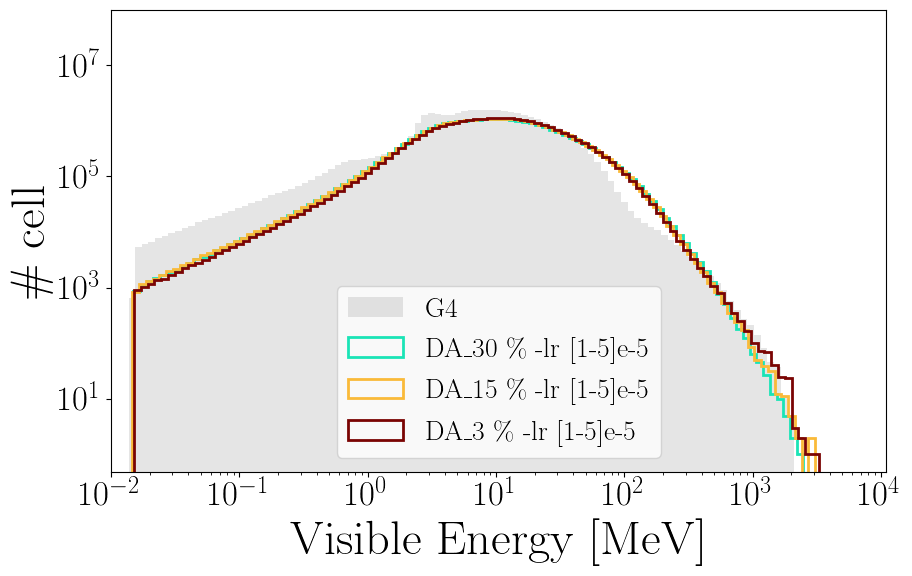

In [35]:

threshold = 0.01515  # the threshold 15.15 KeV
# showers = [showers_origin, showers_FT, showers_DA, showers_DA_1, showers_DA_2] #, showers_DA_3]

# colors = ['gray'] + [plt.get_cmap('turbo')(np.linspace(.1, .9, len(showers)-1))]
# colors = ['gray'] + [cmap(i / (len(showers))) for i in range(1, len(showers))]
cmap = colormaps['turbo']
colors = ['gray'] + [cmap(i / (len(showers)-1)) for i in range(1, len(showers))]
plt.figure(figsize=(10, 6))

for i, shower in tqdm(enumerate(showers[:]), desc='Plotting histograms'):
    visible_shower = shower[(shower != 0) & (shower > threshold)]
    plt.hist(visible_shower, bins=np.logspace(np.log(1e-7), np.log(visible_shower.max()), 200, base=np.e),
            color=colors[i], alpha=0.2 if i == 0 else 1, linewidth=2. if i == 0 else 2,
            histtype='stepfilled' if i == 0 else 'step', label=labels[i])

plt.xscale('log')
plt.yscale('log')
plt.ylim(ymax=1e8)
plt.xlim(xmin=1e-2)

plt.xlabel('Visible Energy [MeV]')
plt.ylabel('\# cell')

plt.legend(fontsize=20, frameon=True)

plt.show()


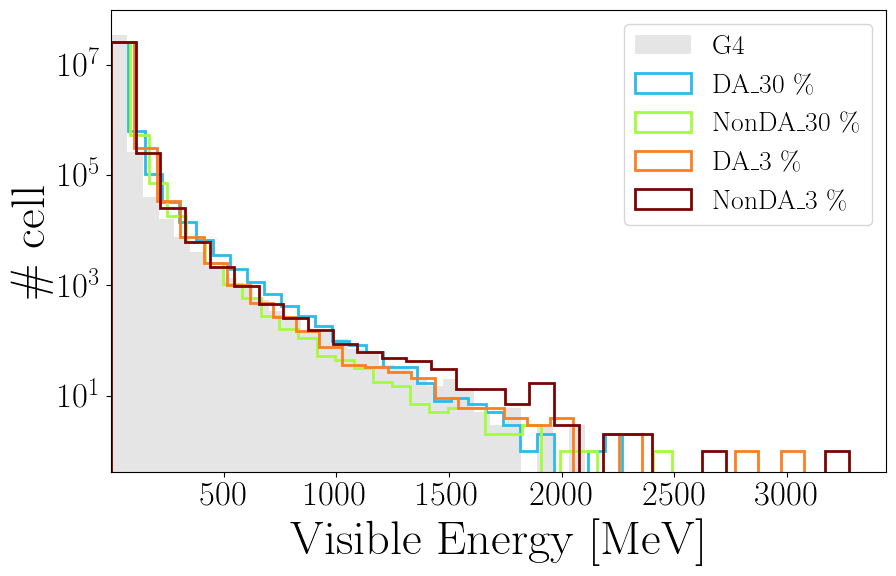

In [9]:

threshold = 0.01515  # the threshold 15.15 KeV
# showers = [showers_origin, showers_FT, showers_DA, showers_DA_1, showers_DA_2] #, showers_DA_3]

# colors = ['gray'] + [plt.get_cmap('turbo')(np.linspace(.1, .9, len(showers)-1))]
# colors = ['gray'] + [cmap(i / (len(showers))) for i in range(1, len(showers))]
# cmap = colormaps['turbo']
# colors = ['gray'] + [cmap(i / (len(showers))) for i in range(1, len(showers))]
plt.figure(figsize=(10, 6))

for i, shower in enumerate(showers):
    visible_shower = shower[(shower != 0) & (shower > threshold)]
    plt.hist(visible_shower, bins=30,
            color=colors[i], alpha=0.2 if i == 0 else 1, linewidth=2. if i == 0 else 2,
            histtype='stepfilled' if i == 0 else 'step', label=labels[i])

# plt.xscale('log')
plt.yscale('log')
plt.ylim(ymax=1e8)
plt.xlim(xmin=1e-2)

plt.xlabel('Visible Energy [MeV]')
plt.ylabel('\# cell')

plt.legend(fontsize=20, frameon=True)

plt.show()


In [10]:

def quantiled_kl_divergence(sample_1: np.ndarray, sample_2: np.ndarray, quantiles_: tuple=(0.001, 0.999),bins: int = 50, labels: list = ['MC', 'Generated']):
    "Calculate the kl divergence using quantiles on sample_1 to define the bounds" ""
    bins = np.quantile(sample_1, np.linspace(quantiles_[0], quantiles_[1], bins))
    hist_1 = np.histogram(sample_1, bins, density=True)[0] + 1e-8 
    hist_2 = np.histogram(sample_2, bins, density=True)[0] + 1e-8
    kl_divergence = entropy(hist_1, hist_2)
    
    # Plot histograms
    # plt.figure(figsize=(10, 6))
    # plt.hist(sample_1, bins=bins, density=False, alpha=1, color='gray', label=labels[0])
    # plt.hist(sample_2, bins=bins, density=False, alpha=0.5, color='orange', label=labels[1])
    # plt.xlabel('')
    # plt.ylabel('')
    # plt.legend(loc='best')
    # plt.show()
    
    return kl_divergence

In [11]:
kl_divergences = [[] for _ in range(len(showers[1:]))]
quantiles_kl = [[] for _ in range(len(showers[1:]))]

visible_MC = showers_origin[(showers_origin != 0) & (showers_origin > threshold)]
hist_MC, _ = np.histogram(visible_MC, bins=np.logspace(np.log(1e-7), np.log(visible_MC.max()), 200, base=np.e))
hist_MC_adjusted = hist_MC + 1e-16

for i, shower in enumerate(showers[1:]):
    visible_shower = shower[(shower != 0) & (shower > threshold)]
    hist_shower, _ = np.histogram(visible_shower, bins=np.logspace(np.log(1e-7), np.log(visible_shower.max()), 200, base=np.e))
    hist_shower_adjusted = hist_shower + 1e-16
    kl_divergence = entropy(pk=hist_MC_adjusted, qk=hist_shower_adjusted)
    kl_quantile = quantiled_kl_divergence(visible_MC, visible_shower, bins=30, labels=['MC', f'{labels[i+1]}'])
    kl_divergences[i].append(kl_divergence)
    quantiles_kl[i].append(kl_quantile)
    print(f'KL Divergence {labels[i+1]}: {kl_divergence:.5f}')
    print(f'KL Divergence {labels[i+1]} using quantiles: {kl_quantile:.6f}')

print('\n' + '+ - ' * 10)
print(*kl_divergences, sep='\n')
print('+ - ' * 10)
print(*quantiles_kl, sep='\n')

KL Divergence DA_30 \%: 0.03960
KL Divergence DA_30 \% using quantiles: 0.021360
KL Divergence NonDA_30 \%: 0.02773
KL Divergence NonDA_30 \% using quantiles: 0.019722
KL Divergence DA_3 \%: 0.02506
KL Divergence DA_3 \% using quantiles: 0.020862
KL Divergence NonDA_3 \%: 0.02627
KL Divergence NonDA_3 \% using quantiles: 0.027321

+ - + - + - + - + - + - + - + - + - + - 
[0.03960184787398034]
[0.027733341318908533]
[0.025061323796820387]
[0.026267267909042897]
+ - + - + - + - + - + - + - + - + - + - 
[0.02136000588502725]
[0.019722296970257062]
[0.02086199836149525]
[0.027321262475667414]


## Calibration curve

In [28]:
incident_energies = [incident_energies_0] + [globals()[f'incident_energies_{i}'] for i in range(1, len(showers))]


In [30]:
incident_energies


[array([[17.87210071],
        [27.19362742],
        [76.35236679],
        ...,
        [76.77045837],
        [70.67019463],
        [69.41851258]]),
 array([10.004841 , 10.0057335, 10.00791  , ..., 89.9764   , 89.98584  ,
        89.991005 ], dtype=float32),
 array([10.004841 , 10.0057335, 10.00791  , ..., 89.9764   , 89.98584  ,
        89.991005 ], dtype=float32),
 array([10.004841 , 10.0057335, 10.00791  , ..., 89.9764   , 89.98584  ,
        89.991005 ], dtype=float32)]

Plotting histograms: 0it [00:00, ?it/s]

(15921,)
(15921, 1)


Plotting histograms: 0it [00:03, ?it/s]


ValueError: The 'color' keyword argument must have one color per dataset, but 15921 datasets and 1 colors were provided

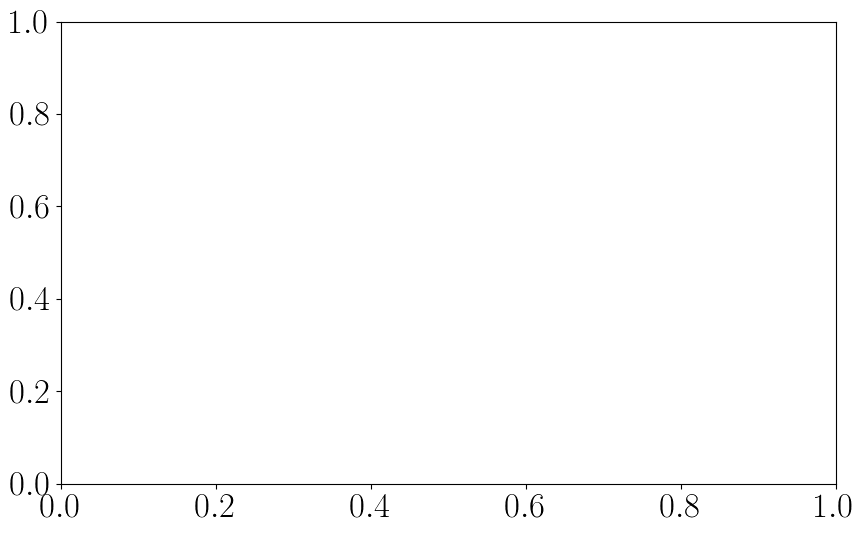

In [44]:
cmap = plt.get_cmap('turbo')
colors = ['gray'] + [cmap(i / (len(showers) - 1)) for i in range(1, len(showers))]
plt.figure(figsize=(10, 6))

# Per memorizzare i valori medi di calibrazione per ciascuna doccia
mean_calibrations = []

for i, (shower, ie) in tqdm(enumerate(zip(showers, incident_energies)), desc='Plotting histograms'):
    # Filtra i valori zero o inferiori alla soglia
    visible_shower = shower[(shower != 0) & (shower > threshold)]
    
    # Tagliare per garantire che len(visible_shower) == len(ie)
    if len(visible_shower) != len(ie):
        min_len = min(len(visible_shower), len(ie))
        visible_shower = visible_shower[:min_len]
        ie = ie[:min_len]

    print(visible_shower.shape)
    print(ie.shape)

    # Calcolo della calibrazione per blocchi
    chunk_size = len(visible_)
    calibration_chunks = []
    for start in range(0, len(visible_shower), chunk_size):
        end = min(start + chunk_size, len(visible_shower))
        calibration_chunk = visible_shower[start:end] / ie[start:end]  # Associazione corretta dell'energia incidente
        calibration_chunks.append(calibration_chunk)

    # Concatenare tutti i segmenti insieme
    calibration = np.concatenate(calibration_chunks)

    # Aggiungi la calibrazione media per la doccia corrente
    mean_calibrations.append(np.mean(calibration))

    plt.hist(calibration, bins=np.logspace(np.log(1e-7), np.log(visible_shower.max()), 200, base=np.e),
             color=colors[i], alpha=0.2 if i == 0 else 1, linewidth=2. if i == 0 else 2,
             histtype='stepfilled' if i == 0 else 'step', label=labels[i])

# Aggiungi i valori medi di calibrazione alla legenda
for i, mean_calibration in enumerate(mean_calibrations):
    plt.axvline(mean_calibration, color=colors[i], linestyle='--', linewidth=2,
                label=f'{labels[i]} mean: {mean_calibration:.2e}')

plt.xscale('log')
plt.yscale('log')
plt.ylim(ymax=1e8)
plt.xlim(xmin=1e-2)

plt.xlabel('Visible Energy [MeV]')
plt.ylabel('# cell')

plt.legend(fontsize=20, frameon=True)

plt.show()

Plotting histograms: 4it [00:21,  5.35s/it]


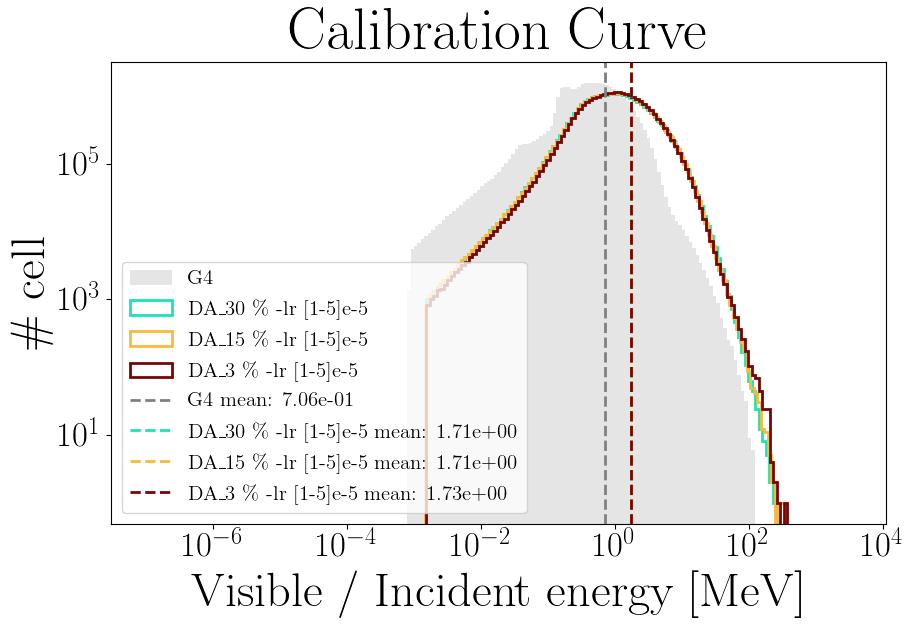

In [7]:

threshold = 0.01515  # the threshold 15.15 KeV
# showers = [showers_origin, showers_FT, showers_DA, showers_DA_1, showers_DA_2] #, showers_DA_3]

# colors = ['gray'] + [plt.get_cmap('turbo')(np.linspace(.1, .9, len(showers)-1))]
# colors = ['gray'] + [cmap(i / (len(showers))) for i in range(1, len(showers))]

cmap = plt.get_cmap('turbo')
colors = ['gray'] + [cmap(i / (len(showers)-1)) for i in range(1, len(showers))]
plt.figure(figsize=(10, 6))

# For storing mean calibration values for each shower
mean_calibrations = []

for i, shower in tqdm(enumerate(showers[:]), desc='Plotting histograms'):
    visible_shower = shower[(shower != 0) & (shower > threshold)]
    
    # Calculate calibration in chunks
    chunk_size = len(visible_shower)
    calibration_chunks = []
    for start in range(0, len(visible_shower), chunk_size):
        end = min(start + chunk_size, len(visible_shower))
        if i == 0:
            calibration_chunk = visible_shower[start:end] / incident_energies_0[start % len(incident_energies_0)]
        else:
            calibration_chunk = visible_shower[start:end] / incident_energies_1[start % len(incident_energies_1)]

        calibration_chunks.append(calibration_chunk)
    
    # Concatenate all chunks together
    calibration = np.concatenate(calibration_chunks)
    
    # Append the mean calibration for the current shower
    mean_calibrations.append(np.mean(calibration))
    
    plt.hist(calibration, bins=np.logspace(np.log(1e-7), np.log(visible_shower.max()), 200, base=np.e),
             color=colors[i], alpha=0.2 if i == 0 else 1, linewidth=2. if i == 0 else 2,
             histtype='stepfilled' if i == 0 else 'step', label=labels[i])

# Add the mean calibration values to the legend
for i, mean_calibration in enumerate(mean_calibrations):
    plt.axvline(mean_calibration, color=colors[i], linestyle='--', linewidth=2, 
                label=f'{labels[i]} mean: {mean_calibration:.2e}')

plt.xscale('log')
plt.yscale('log')
# plt.ylim(ymax=1e8)
# plt.xlim(xmin=1e-2)

plt.title('Calibration Curve')
plt.xlabel('Visible / Incident energy [MeV]')
plt.ylabel('\# cell')

plt.legend(fontsize=15, frameon=True, loc='best')

plt.show()


In [54]:
print(visible_shower)
print('\n', '+ - ' * 10, '\n')

print(incident_energies_1)
print('\n', '+ - ' * 10, '\n')
print(incident_energies_0)

[ 4.7109275   0.29417434  0.18229882 ...  3.4903662  10.31188
  4.5985413 ]

 + - + - + - + - + - + - + - + - + - + -  

[10.004841  10.0057335 10.00791   ... 89.9764    89.98584   89.991005 ]

 + - + - + - + - + - + - + - + - + - + -  

[[17.8721  ]
 [27.193628]
 [76.35236 ]
 ...
 [76.77046 ]
 [70.6702  ]
 [69.41851 ]]


In [53]:
incident_energies_0 = np.array(incident_energies_0, dtype=np.float32)
# Appiattire la matrice bidimensionale in un array monodimensionale
incident_energies_0_flat = incident_energies_0.flatten()
# Ordina l'array monodimensionale
sorted_energies = np.sort(incident_energies_0_flat)

print(sorted_energies)

[10.004841  10.0057335 10.00791   ... 89.9764    89.98584   89.991005 ]


## Radial Energy

 0 e' il numero di shower, 1 posizione e' coordinata z, 2 posizione coordinata phi, e 3 poszione e' coordinata r. voglio un array finale con 15921,x,y,z

5it [00:00, 865.95it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


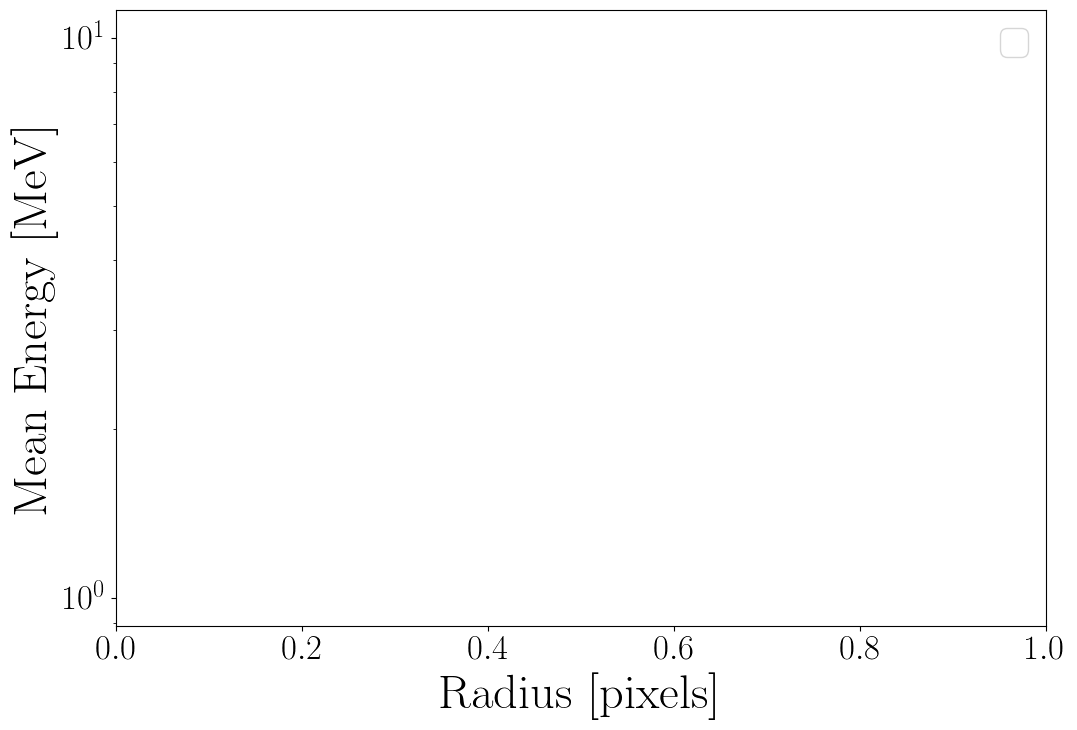

In [11]:
plt.figure(figsize=(12, 8))
cmap = colormaps['turbo']
colors = ['gray'] + [cmap(i / len(showers)) for i in range(1, len(showers))]


for i, shower in tqdm(enumerate(showers)):
     # get radial profile #######################
    shower_reshaped = shower.reshape(shower.shape[0], 45, 50, 18)
    x_hit_idx, z_hit_idx = np.where(np.nonzero(shower[1]))

    # x_cell_coord = MAP[l]['xedges'][:-1][x_hit_idx] + half_cell_size_global
    # z_cell_coord = MAP[l]['zedges'][:-1][z_hit_idx] + half_cell_size_global
    # e_cell = layer[x_hit_idx, z_hit_idx]
    # dist_to_origin = np.sqrt((x_cell_coord - incident_point[0])**2 + (z_cell_coord - incident_point[1])**2)
    # e_radial.append([dist_to_origin, e_cell]) 
    # e_radial_layers.append([dist_to_origin, e_cell])
    # # Plot the histogram
    # plt.hist(levels, bins=18, weights=mean_energy_per_level, color=colors[i], 
    #          alpha=0.2 if i == 0 else 1, linewidth=2 if i == 0 else 2,  
    #          histtype='stepfilled' if i == 0 else 'step', label=labels[i])

plt.xlabel('Radius [pixels]')
plt.ylabel('Mean Energy [MeV]')
plt.yscale('log')  # Using a logarithmic scale on the y-axis
plt.xlim(0,)
plt.legend(fontsize=26, frameon=True)
plt.show()

In [83]:
radial_MC = showers_origin.reshape(showers_origin.shape[0], 45, 50, 18)
# Sum over axes 0 and 1 to collapse these dimensions
summed_axes_MC = np.sum(radial_MC, axis=(0, 1))
# Now calculate the mean of the resulting array along the remaining axis (which could be axis 0 if only one axis remains after summing)
mean_values_MC = np.mean(summed_axes_MC, axis=0)  # Adjust axis according to the actual number of dimensions
# print("Mean values shape:", mean_values_MC)
# Create a histogram using the mean values
hist_MC, bins_edges = np.histogram(np.arange(18), bins=18, weights=mean_values_MC)
hist_MC_adjusted = hist_MC + 1e-16

for i, shower in enumerate(showers[1:]):
    radial_shower = shower.reshape(shower.shape[0], 45, 50, 18)
    # Sum over axes 0 and 1 to collapse these dimensions
    summed_axes = np.sum(radial_shower, axis=(0, 1))

    # Now calculate the mean of the resulting array along the remaining axis (which could be axis 0 if only one axis remains after summing)
    mean_values = np.mean(summed_axes, axis=0)  # Adjust axis according to the actual number of dimensions
    # print("Mean values shape:", mean_values.shape)
    # print("Mean values:", mean_values)
    # Create a histogram using the mean values
    hist_shower, bins_edges = np.histogram(np.arange(18), bins=18, weights=mean_values)
    hist_shower_adjusted = hist_MC + 1e-16
    
    kl_divergence = entropy(pk=hist_MC_adjusted, qk=hist_shower_adjusted)
    # kl_divergences[i].append(kl_divergence)
    print(f'KL Divergence {i+1}: {kl_divergence:.4f}')
    kl_quantile = quantiled_kl_divergence(mean_values_MC, mean_values, bins=30)
    # quantiles_kl[i].append(kl_quantile)
    print(f'KL Divergence {i+1} using quantiles: {kl_quantile:.6f}')

# print(*kl_divergences, sep='\n')
print('+ - ' * 20)
# print(*quantiles_kl, sep='\n')

KL Divergence 1: 0.0000
KL Divergence 1 using quantiles: 2.691662
KL Divergence 2: 0.0000
KL Divergence 2 using quantiles: 4.054076
+ - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - 


## Energy sum

Plotting histograms: 2it [00:00,  4.46it/s]

2960.6951998145205 75892.06848987596
2861.8472 75892.07


Plotting histograms: 4it [00:00,  5.17it/s]

2867.8398 75892.08
2112.5735 75892.06


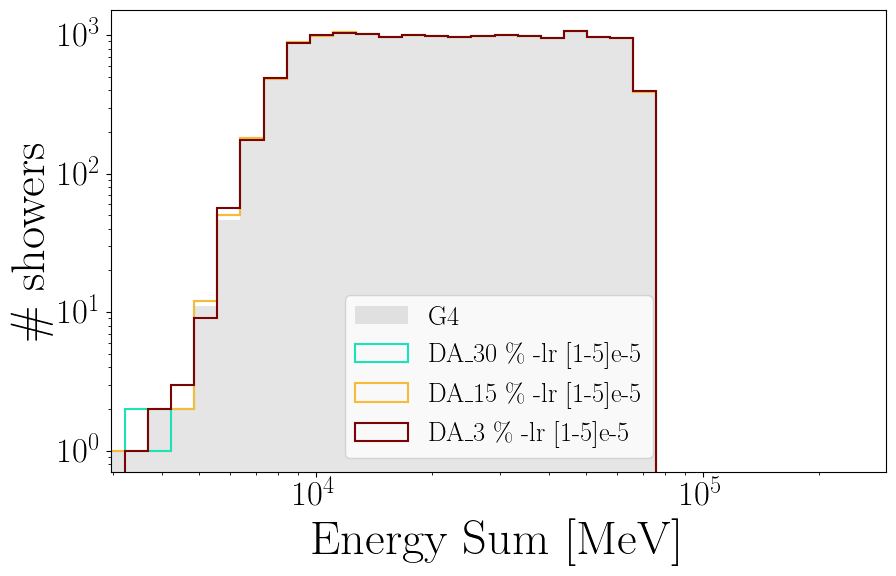

In [36]:
plt.figure(figsize=(10, 6))

for i, shower in tqdm(enumerate(showers), desc='Plotting histograms'):
    sum_shower = shower.sum(-1)
    print(sum_shower.min(), sum_shower.max())
    plt.hist(sum_shower, bins=np.logspace(np.log(1e-7), np.log(sum_shower.max()), 200, base=np.e),
            color=colors[i], alpha=0.2 if i == 0 else 1, linewidth=2. if i == 0 else 1.5,
            histtype='stepfilled' if i == 0 else 'step', label=labels[i])
    if i == 0:  
        xmin = sum_shower.min()

plt.xscale('log')

plt.xlim(xmin=xmin)

plt.xlabel('Energy Sum [MeV]')
plt.ylabel('\# showers')
plt.yscale('log')

plt.legend(fontsize=19, frameon=True)
# plt.savefig('energy_sum.png')
plt.show()

In [35]:
sum_MC = showers_origin.sum(-1)
hist_MC, _ = np.histogram(sum_MC, bins=np.logspace(np.log(1e-7), np.log(sum_MC.max()), 200, base=np.e))
hist_MC_adjusted = hist_MC + 1e-16

for i, shower in enumerate(showers[1:]):
    sum_shower = shower.sum(-1)
    hist_shower, _ = np.histogram(sum_shower, bins=np.logspace(np.log(1e-7), np.log(sum_shower.max()), 200, base=np.e))
    hist_shower_adjusted = hist_shower + 1e-16
    kl_divergence = entropy(pk=hist_MC_adjusted, qk=hist_shower_adjusted)
    kl_divergences[i].append(kl_divergence)
    print(f'KL Divergence {labels[i+1]}: {kl_divergence:.4f}')
    kl_quantile = quantiled_kl_divergence(sum_MC, sum_shower, bins=30)
    quantiles_kl[i].append(kl_quantile)
    print(f'KL Divergence {labels[i+1]} using quantiles: {kl_quantile:.6f}')

print(*kl_divergences, sep='\n')
print('+ - ' * 20)
print(*quantiles_kl, sep='\n')

KL Divergence DA_30 \%: 0.0000
KL Divergence DA_30 \% using quantiles: 0.000042
KL Divergence NonDA_30 \%: 0.0000
KL Divergence NonDA_30 \% using quantiles: 0.000039
KL Divergence DA_15 \%: 0.0025
KL Divergence DA_15 \% using quantiles: 0.000092
KL Divergence NonDA_15 \%: 0.0023
KL Divergence NonDA_15 \% using quantiles: 0.000038
[0.03960184787398034, 8.181324315979462e-06]
[0.04811316756087247, 1.0181990806891749e-05]
[0.0632266321876189, 0.002453484634292304]
[0.04307578464495631, 0.0023469962581237304]
+ - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - 
[0.02136000588502725, 4.1725119501719e-05]
[0.01578537303045925, 3.8781752909016986e-05]
[0.023878131766752957, 9.227836751378091e-05]
[0.0203174047898855, 3.8162215384788074e-05]


In [11]:
# kl_divergences_trimmed = [arr[:-6] for arr in kl_divergences]

# # Eliminazione degli ultimi 6 elementi da ogni array in quantiles_kl
# quantiles_kl_trimmed = [arr[:-6] for arr in quantiles_kl]
# kl_divergences = kl_divergences_trimmed
# quantiled_kl_divergence = quantiles_kl_trimmed
# # Stampa degli array di array risultanti
# print(*kl_divergences_trimmed, sep='\n')
# # print('+ - ' * 10)
# print(*quantiles_kl_trimmed, sep='\n')

## n_hits

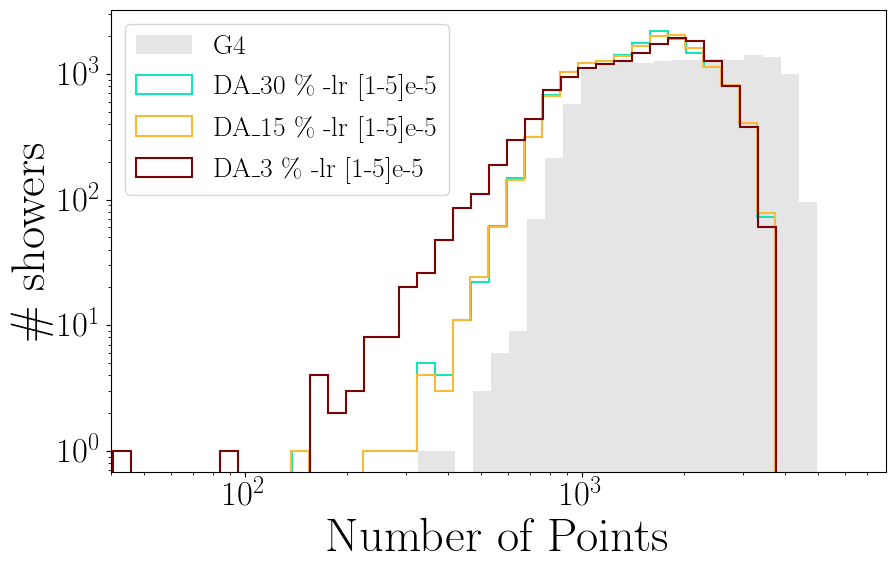

In [37]:
plt.figure(figsize=(10, 6))

for i, shower in enumerate(showers):
    hits_shower = np.count_nonzero(shower, axis=-1)
    plt.hist(hits_shower, bins=np.logspace(np.log(1e-7), np.log(hits_shower.max()), 200, base=np.e),
            color=colors[i], alpha=0.2 if i == 0 else 1, linewidth=2. if i == 0 else 1.5,
            histtype='stepfilled' if i == 0 else 'step', label=labels[i])
    if i == 0:  
        xmin = hits_shower.min()
        xmax = hits_shower.max() + 3e3

plt.xscale('log')
plt.yscale('log')
plt.xlim(xmin=4e1, xmax = xmax)

plt.xlabel('Number of Points')
plt.ylabel('\# showers')

plt.legend(fontsize=20, frameon=True)

plt.show()

In [54]:

# threshold = 0.01515

# showers = [showers_FT, showers_DA, showers_DA_1, showers_DA_2, showers_DA_3]
# kl_divergences = [[] for _ in range(5)]

hits_MC = np.count_nonzero(showers_origin, axis=1)
hist_MC, _ = np.histogram(hits_MC, bins=np.logspace(np.log(1e-7), np.log(hits_MC.max()), 200, base=np.e)) 
hist_MC_adjusted = hist_MC + 1e-16

for i, shower in enumerate(showers[1:]):
    hits_shower = np.count_nonzero(shower, axis=1)
    hist_shower, _ = np.histogram(hits_shower, bins=np.logspace(np.log(1e-7), np.log(hits_shower.max()), 200, base=np.e)) 
    hist_shower_adjusted = hist_shower + 1e-16
    kl_divergence = entropy(pk=hist_MC_adjusted, qk=hist_shower_adjusted)
    kl_divergences[i].append(kl_divergence)
    print(f'KL Divergence {i+1}: {kl_divergence:.4f}')
    
    kl_quantile = quantiled_kl_divergence(hits_MC, hits_shower, quantiles_=(0.001,0.990), bins= 30)
    quantiles_kl[i].append(kl_quantile)
    print(f'KL Divergence {i+1} using quantiles: {kl_quantile:.6f}')

print(*kl_divergences, sep='\n')
print('+ - ' * 20)  
print(*quantiles_kl, sep='\n')

KL Divergence 1: 0.0809
KL Divergence 1 using quantiles: 0.489307
KL Divergence 2: 0.0839
KL Divergence 2 using quantiles: 0.501210
[0.03960184787398034, 0.08093214185481713]
[0.04811316756087247, 0.08390723820650683]
+ - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - 
[0.02136000588502725, 0.48930687773249587]
[0.01578537303045925, 0.5012097124716258]


## Energy Sum vs Layers

Reshaped G4 form: (15921, 45, 50, 18)
Reshaped DA_30 \% -lr [1-5]e-5 form: (15921, 45, 50, 18)
Reshaped DA_15 \% -lr [1-5]e-5 form: (15921, 45, 50, 18)
Reshaped DA_3 \% -lr [1-5]e-5 form: (15921, 45, 50, 18)


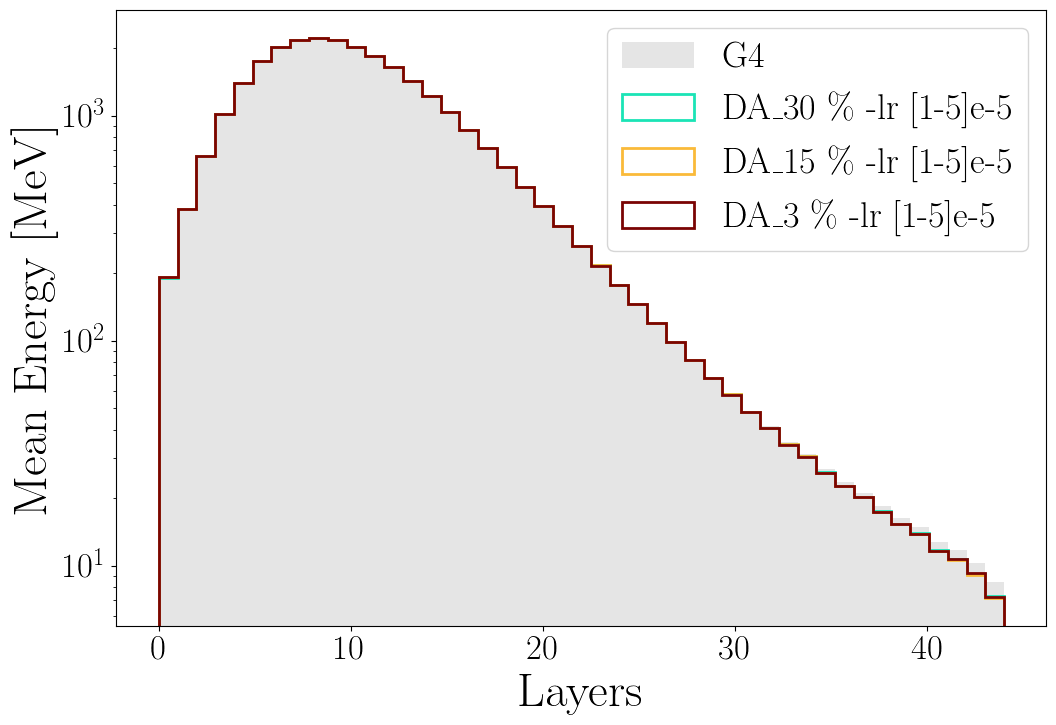

In [38]:
plt.figure(figsize=(12, 8))
# cmap = colormaps['turbo']
# colors = ['gray'] + [cmap(i / len(showers)) for i in range(1, len(showers))]

for i, array in enumerate(showers):
    
    # Reshape the array if necessary, ensuring the shape is (n_shower, 45, 50, 18)
    # In your specific case, it appears to be already correct, so no need to reshape again.
    array_reshaped = array.reshape(array.shape[0], 45, 50, 18)
    print(f"Reshaped {labels[i]} form:", array_reshaped.shape)
    # Calculate the energy sum across the y and z axes
    energy_sums = np.sum(array_reshaped, axis=(2, 3))
    # Calculate the mean energy per x level
    mean_energy_per_level = np.mean(energy_sums, axis=0)    
    # Indices for the 45 levels
    levels = np.arange(45)
    
    # Plot the histogram
    plt.hist(levels, bins=45, weights=mean_energy_per_level, color=colors[i], 
             alpha=0.2 if i == 0 else 1, linewidth=2 if i == 0 else 2,  
             histtype='stepfilled' if i == 0 else 'step', label=labels[i])

plt.xlabel('Layers')
plt.ylabel('Mean Energy [MeV]')
plt.yscale('log')  # Using a logarithmic scale on the y-axis
plt.legend(fontsize=26, frameon=True)
plt.show()

In [13]:

showers_origin_reshaped = showers_origin.reshape(showers_origin.shape[0], -1, 45)
energy_sum_MC = np.sum(showers_origin_reshaped, axis=(0, 1))
# print(energy_sum_MC)
hist_MC, _ = np.histogram(range(len(energy_sum_MC)), bins=45, weights=energy_sum_MC)
hist_MC_adjusted = hist_MC + 1e-16

for i, shower in enumerate(showers[1:]):
    showers_reshaped = shower.reshape(shower.shape[0], -1, 45)
    energy_sum_shower = np.sum(showers_reshaped, axis=(0, 1))
    # print(energy_sum_shower)
    hist_shower, _ = np.histogram(range(len(energy_sum_shower)), bins=45, weights=energy_sum_shower)
    hist_shower_adjusted = hist_shower + 1e-16
    kl_divergence = entropy(pk=hist_MC_adjusted, qk=hist_shower_adjusted)
    # kl_divergences[i].append(kl_divergence)
    print(f'KL Divergence {i+1}: {kl_divergence:.4f}')

    quantiled_kl_divergence_value = quantiled_kl_divergence(energy_sum_MC, energy_sum_shower, quantiles_=(0,1) ,bins=30, )
    quantiles_kl[i].append(kl_divergence)
    print(f'KL Divergence {i+1} using quantiles: {quantiled_kl_divergence_value:.6f}')

print(*kl_divergences, sep='\n')

print('+ - ' * 20)

print(*quantiles_kl, sep='\n')

KL Divergence 1: 0.0002
KL Divergence 1 using quantiles: 1.748671
KL Divergence 2: 0.0002
KL Divergence 2 using quantiles: 1.742974
KL Divergence 3: 0.0014
KL Divergence 3 using quantiles: 2.709936
KL Divergence 4: 0.0015
KL Divergence 4 using quantiles: 1.853424
[0.15950991118901353, 0.21494094642383246, 0.3073794875226386]
[0.14363210755226108, 0.2210772105418906, 0.30651133087300275]
[0.16097044317489986, 0.18037570532630953, 0.3973271409727859]
[0.1649149086956952, 0.1765174655378575, 0.4876752029759026]
+ - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - 
[0.07320752515036281, 0.50606170123604, 0.327056601030441, 0.000226646273713518]
[0.07285563988376478, 0.5049548444368295, 0.32630490020209346, 0.00022805807986292097]
[0.048971179160692976, 0.22503775468350262, 0.41889322746751145, 0.001443809374194837]
[0.04882902207638583, 0.21572933106415748, 0.406317723882976, 0.0014506538205233534]


In [14]:

print(*kl_divergences, sep='\n')

print('+ - ' * 20)

print(*quantiles_kl, sep='\n')

[0.15950991118901353, 0.21494094642383246, 0.3073794875226386]
[0.14363210755226108, 0.2210772105418906, 0.30651133087300275]
[0.16097044317489986, 0.18037570532630953, 0.3973271409727859]
[0.1649149086956952, 0.1765174655378575, 0.4876752029759026]
+ - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - 
[0.07320752515036281, 0.50606170123604, 0.327056601030441, 0.000226646273713518]
[0.07285563988376478, 0.5049548444368295, 0.32630490020209346, 0.00022805807986292097]
[0.048971179160692976, 0.22503775468350262, 0.41889322746751145, 0.001443809374194837]
[0.04882902207638583, 0.21572933106415748, 0.406317723882976, 0.0014506538205233534]


### KL averaged

In [15]:
kl_divergences_ = np.array(kl_divergences)
means = []
pathis = []

for i in range(len(kl_divergences_)):
    pathi = path_list[i].removeprefix(prefix).removesuffix(".pt_ema_steps_32/showers.hdf5")
    pathis.append(pathi)
    print(f'KL for the path: \n {pathi}')
    # mean = np.mean(kl_divergences_[i])
    # means.append(mean)
    # print(f'The mean for the {labels[i+1]} {i+1}: \n', round(mean, 6), '\n')

KL for the path: 
 CaloChallange_CD2024_04_06__12_30_51_ckpt_0.000000_800000.pt_ema_steps_32
KL for the path: 
 CaloChallange_CD2024_04_04__18_22_33_ckpt_0.000000_800000.pt_ema_steps_32
KL for the path: 
 CaloChallange_CD2024_02_23__11_14_11_ckpt_0.000000_800000.pt_ema_steps_32
KL for the path: 
 CaloChallange_CD2024_02_23__11_08_12_ckpt_0.000000_800000.pt_ema_steps_32


## TODO: nHits, eSum, radial energy, and cell energy distribution 


NameError: name 'showers_FT' is not defined

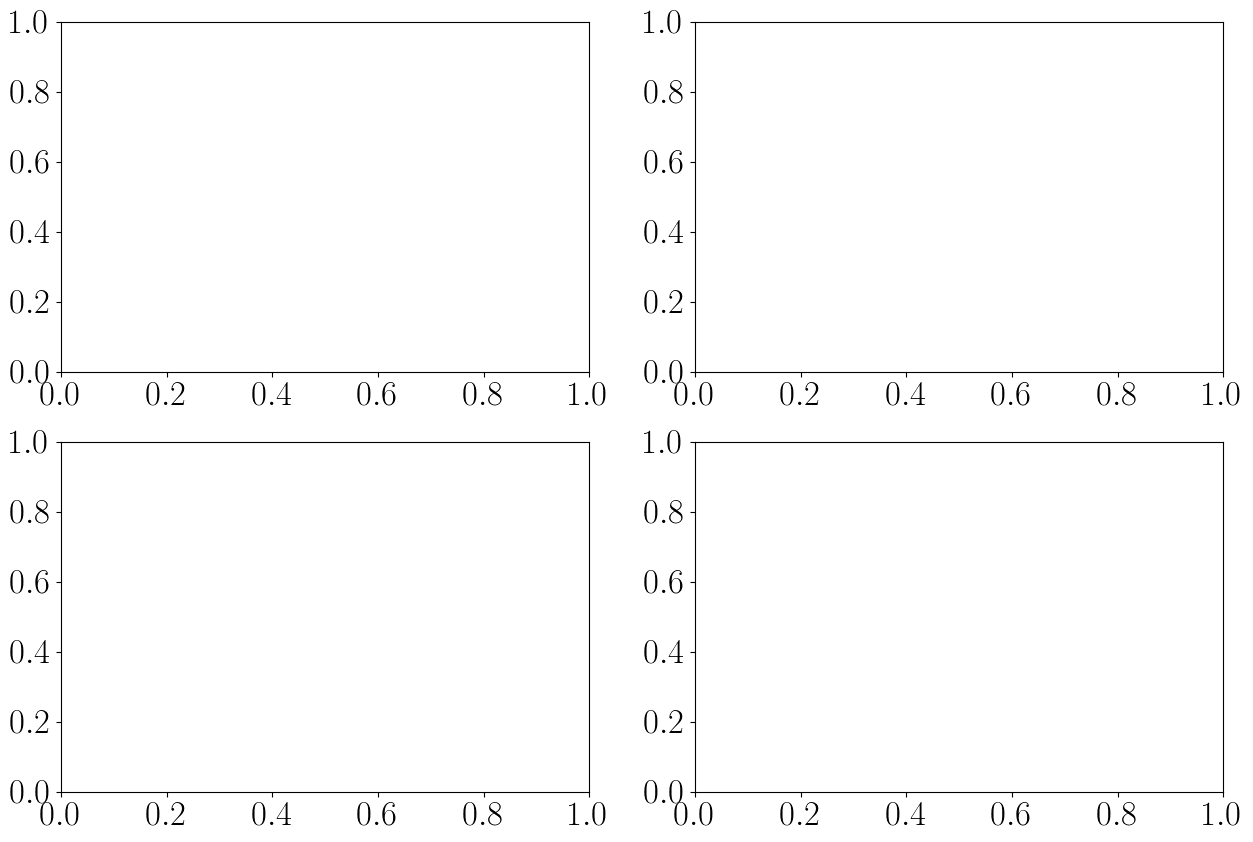

In [18]:
from scipy.stats import chisquare, entropy, wasserstein_distance

threshold = 0.01515
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

# List of visible energy arrays
visible_arrays = [showers_origin, showers_FT, showers_DA, showers_DA_1, showers_DA_2, showers_DA_3]

# List of colors for plotting
colors = ['gray', 'red', 'blue', 'green', 'orange']

# Iterate over visible arrays and colors to plot histograms
for i, (visible_array, color) in enumerate(zip(visible_arrays, colors)):
    visible = visible_array[(visible_array != 0) & (visible_array > threshold)]
    ax[0, 0].hist(visible, bins=np.logspace(np.log(1e-7), np.log(visible.max()), 100, base=np.e), color=color, alpha=0.8, linewidth=1., histtype='step', label=f'DA {i+1}')

# Set properties for the first subplot
ax[0, 0].set_xscale('log')
ax[0, 0].set_yscale('log')
ax[0, 0].set_ylim(ymax=1e8)
ax[0, 0].set_xlim(xmin=1e-2)
ax[0, 0].set_xlabel('Visible Energy [MeV]')
ax[0, 0].set_ylabel('# cell')
ax[0, 0].legend(fontsize=12)

# List of sum arrays
sum_arrays = [showers_origin.sum(-1), showers_FT.sum(-1), showers_DA.sum(-1), showers_DA_1.sum(-1), showers_DA_2.sum(-1), showers_DA_3.sum(-1)]

# Iterate over sum arrays and colors to plot histograms
for sum_array, color in zip(sum_arrays, colors):
    ax[0, 1].hist(sum_array, bins=np.logspace(np.log(1e-7), np.log(sum_array.max()), 100, base=np.e), color=color, alpha=0.8, linewidth=1., histtype='step', label=f'DA {i+1}')

# Set properties for the second subplot
ax[0, 1].set_xscale('log')
ax[0, 1].set_xlim(xmin=min(sum_arrays[0]))
ax[0, 1].set_xlabel('Energy Sum [MeV]')
ax[0, 1].set_ylabel('# showers')
ax[0, 1].legend(fontsize=12)

# List of hits arrays
hits_arrays = [np.count_nonzero(showers_origin, axis=1), np.count_nonzero(showers_FT, axis=1), np.count_nonzero(showers_DA, axis=1), 
               np.count_nonzero(showers_DA_1, axis=1), np.count_nonzero(showers_DA_2, axis=1), np.count_nonzero(showers_DA_3, axis=1)]

# Iterate over hits arrays and colors to plot histograms
for hits_array, color in zip(hits_arrays, colors):
    ax[1, 0].hist(hits_array, bins=np.logspace(np.log(1e-7), np.log(hits_array.max()), 200, base=np.e), color=color, alpha=0.8, linewidth=1., histtype='step', label=f'DA {i+1}')

# Set properties for the third subplot
ax[1, 0].set_xscale('log')
ax[1, 0].set_xlim(xmin=min(hits_arrays[0]), xmax=max(hits_arrays[0]))
ax[1, 0].set_xlabel('Number of Hits')
ax[1, 0].set_ylabel('# showers')
ax[1, 0].legend(fontsize=12)

# Reshape the showers_origin array into groups of 45 columns
showers_origin_reshaped = showers_origin.reshape(showers_origin.shape[0], -1, 45)
showers_FT_reshaped = showers_FT.reshape(showers_FT.shape[0], -1, 45)
showers_DA_reshaped = showers_DA.reshape(showers_DA.shape[0], -1, 45)
showers_DA_1_reshaped = showers_DA_1.reshape(showers_DA_1.shape[0], -1, 45)
showers_DA_2_reshaped = showers_DA_2.reshape(showers_DA_2.shape[0], -1, 45)
shower_DA_3_reshaped = showers_DA_3.reshape(showers_DA_3.shape[0], -1, 45)

# Calculate the energy sum for each layer in each group for showers_origin
energy_sums = [np.sum(showers_reshaped, axis=(0, 1)) for showers_reshaped in [showers_origin_reshaped, showers_FT_reshaped, showers_DA_reshaped,
                                                                               showers_DA_1_reshaped, showers_DA_2_reshaped, shower_DA_3_reshaped]]

# Iterate over energy sums and colors to plot histograms
for energy_sum, color in zip(energy_sums, colors):
    ax[1, 1].hist(range(len(energy_sum)), bins=45, weights=energy_sum, color=color, alpha=0.8, linewidth=1., histtype='step', label=f'DA {i+1}')

# Set properties for the fourth subplot
ax[1, 1].set_xlabel('Layers')
ax[1, 1].set_ylabel('Energy Sum [MeV]')
ax[1, 1].legend(fontsize=12)

plt.tight_layout()  # Align the plots
plt.show()

## evaluate CG

In [16]:
import matplotlib.pyplot as plt

def extract_numbers(line):
    parts = line.split()
    if len(parts) > 0:
        number = parts[-1]
        try:
            return float(number)
        except ValueError:
            return 0
    else:
        return 0
    
def calculate_std_div_sqrt_n(numbers):
    # Convert numbers to numpy array for easier calculations
    numbers = np.array(numbers)
    
    # Calculate the standard deviation
    std_dev = np.std(numbers)
    
    # Calculate the square root of the sample size
    sqrt_n = np.sqrt(len(numbers))
    
    # Calculate the standard deviation divided by the square root of the sample size
    std_div_sqrt_n = std_dev / sqrt_n
    
    return std_div_sqrt_n

def calculate_average(filename):
    total = 0
    count = 0
    numbers = []  # List to store numbers
    with open(filename, 'r') as file:
        for line in file:
            number = extract_numbers(line)
            total += number
            if number != 0:
                count += 1
                numbers.append(number)  # Append non-zero numbers to the list
    
    # Print summary
    print('\n'*2, ' + '*5, "Summary", ' + '*5,'\n'*2)
    print("Total:", total)
    print("Count:", count)
    
    if count > 0:
        print("Average:", total / count)
        return total / count, numbers, calculate_std_div_sqrt_n(numbers)  # Return average and list of numbers
    else:
        return None, None, None
    


In [17]:
file_names = []
for p in path_list:
    print(p)
    prefixo = p.replace('/showers.hdf5', '')
    file_name = prefixo + '/evaluation/histogram_kl_3.txt'
    file_names.append(file_name)

CaloChallange_CD2024_04_06__12_30_51_ckpt_0.000000_800000.pt_ema_steps_32
CaloChallange_CD2024_04_04__18_22_33_ckpt_0.000000_800000.pt_ema_steps_32
CaloChallange_CD2024_02_23__11_14_11_ckpt_0.000000_800000.pt_ema_steps_32
CaloChallange_CD2024_02_23__11_08_12_ckpt_0.000000_800000.pt_ema_steps_32




  +  +  +  +  +  Summary  +  +  +  +  +  


Total: 14.00864559294415
Count: 180
Average: 0.07782580884968972
CaloChallange_CD2024_04_06__12_30_51_ckpt_0.000000_800000.pt_ema_steps_32
The average of the numbers in the file is: 0.077826 ± 0.002573
the filename is: CaloChallange_CD2024_04_06__12_30_51_ckpt_0.000000_800000.pt_ema_steps_32/evaluation/histogram_kl_3.txt


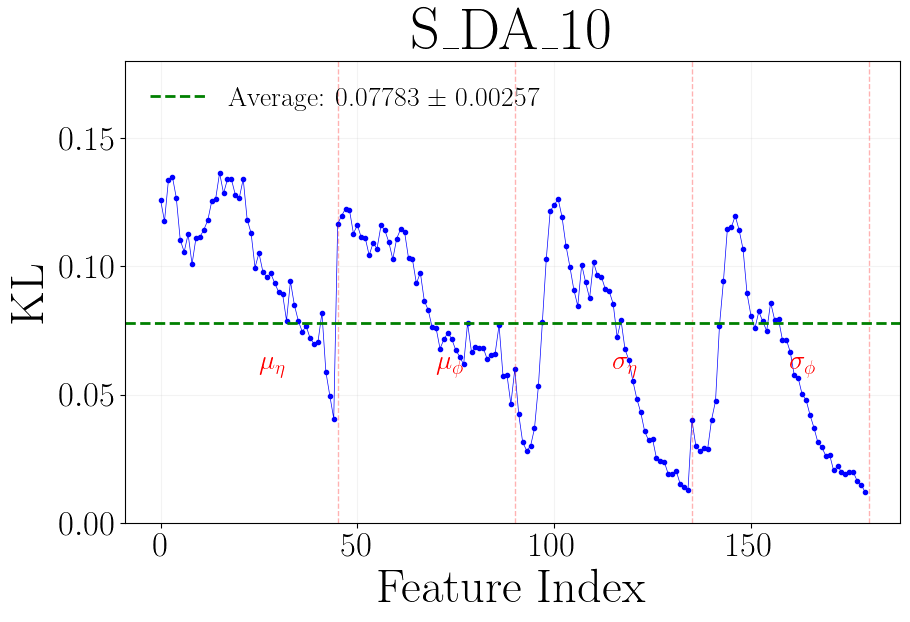



  +  +  +  +  +  Summary  +  +  +  +  +  


Total: 14.019850800342983
Count: 180
Average: 0.07788806000190546
CaloChallange_CD2024_04_04__18_22_33_ckpt_0.000000_800000.pt_ema_steps_32
The average of the numbers in the file is: 0.077888 ± 0.002586
the filename is: CaloChallange_CD2024_04_04__18_22_33_ckpt_0.000000_800000.pt_ema_steps_32/evaluation/histogram_kl_3.txt


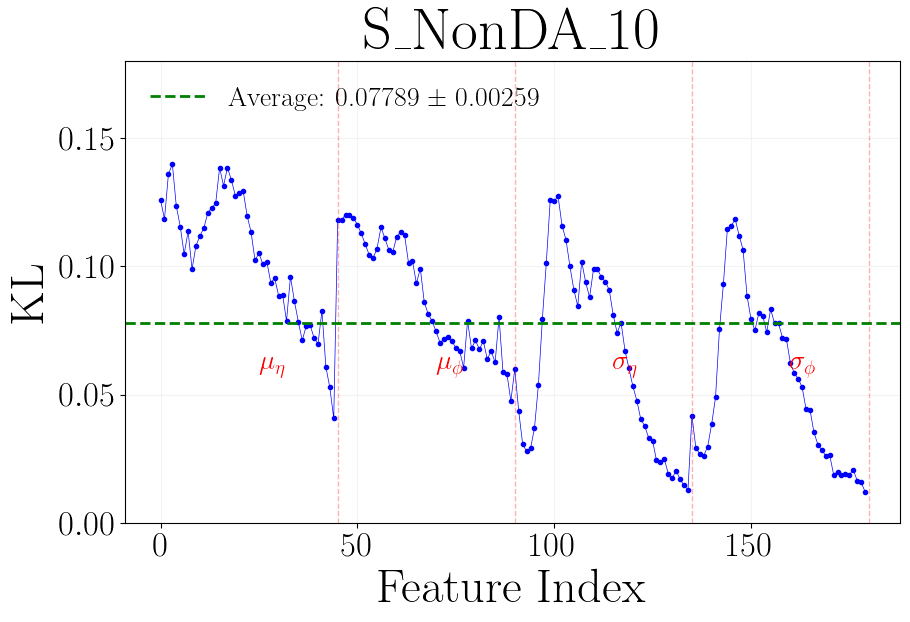



  +  +  +  +  +  Summary  +  +  +  +  +  


Total: 12.343085710938864
Count: 180
Average: 0.06857269839410479
CaloChallange_CD2024_02_23__11_14_11_ckpt_0.000000_800000.pt_ema_steps_32
The average of the numbers in the file is: 0.068573 ± 0.00215
the filename is: CaloChallange_CD2024_02_23__11_14_11_ckpt_0.000000_800000.pt_ema_steps_32/evaluation/histogram_kl_3.txt


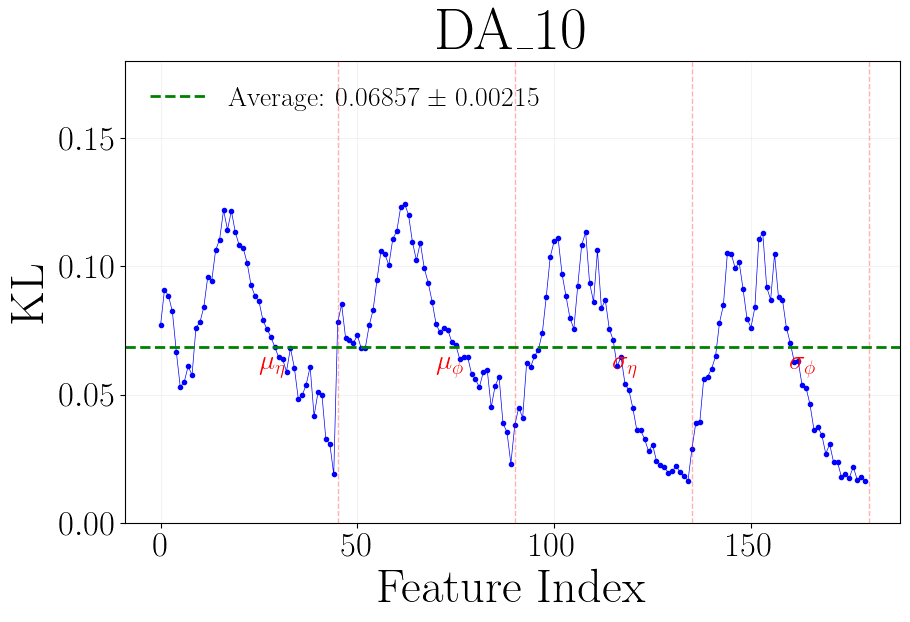



  +  +  +  +  +  Summary  +  +  +  +  +  


Total: 12.308101615711793
Count: 180
Average: 0.06837834230950997
CaloChallange_CD2024_02_23__11_08_12_ckpt_0.000000_800000.pt_ema_steps_32
The average of the numbers in the file is: 0.068378 ± 0.002141
the filename is: CaloChallange_CD2024_02_23__11_08_12_ckpt_0.000000_800000.pt_ema_steps_32/evaluation/histogram_kl_3.txt


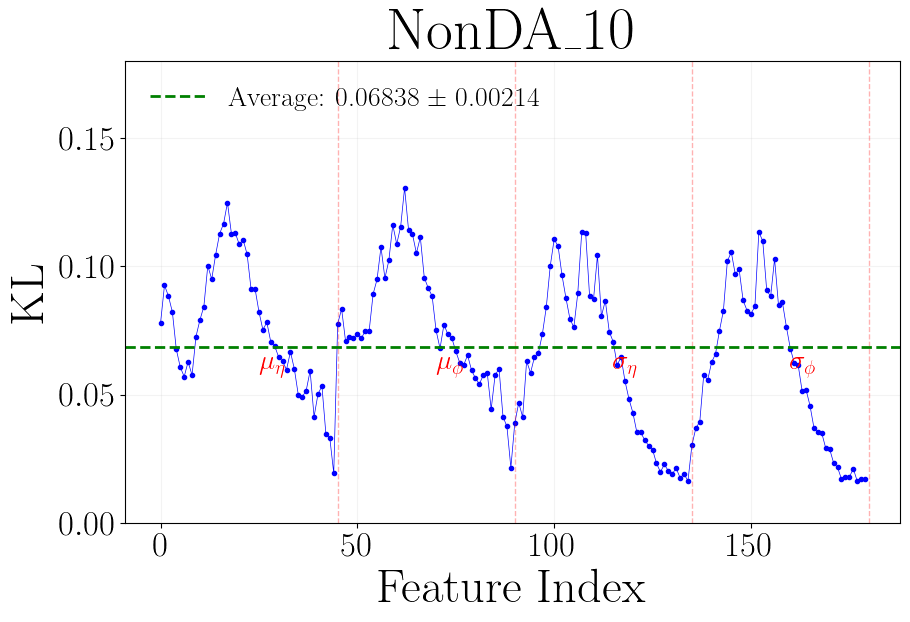

In [18]:

average_cg = []
error_cg = []
# fig_size = (10, 6)
for i, file_name in enumerate(file_names):
   
    # Calculate the average and get the list of numbers
    average, numbers, err = calculate_average(prefix + file_name)
    average_cg.append(average)
    error_cg.append(err)
    print(pathis[i])
    # Print the result
    if average is not None:
        print("The average of the numbers in the file is:", round(average, 6), '±', round(err, 6))
        print('the filename is:', file_name)
        
        # Plot the numbers
        plt.figure(figsize=(10, 6))
        plt.plot(numbers, marker='o', linestyle='-', color='b', markersize=3, linewidth=0.5)
        plt.xlabel('Feature Index')
        plt.ylabel('KL')
        plt.grid(True, alpha=0.15)
        
        # Counter for mu and phi
        mu_phi_counter = 0
        # Counter for symbols
        symbol_counter = 0
        
        for j in np.arange(45, len(numbers)+1, 45):
            plt.axvline(x=j, linestyle='dashed', linewidth=1, color='red', alpha=0.30)
            if symbol_counter == 0:
                plt.text(j - 20, +0.06, r'$\mu_\eta$', fontsize=20, color='red')
            elif symbol_counter == 1:
                plt.text(j - 20, +0.06, r'$\mu_\phi$', fontsize=20, color='red')
            elif symbol_counter == 2:
                plt.text(j - 20, +0.06, r'$\sigma_\eta$', fontsize=20, color='red')
            else:
                plt.text(j - 20, +0.06, r'$\sigma_\phi$', fontsize=20, color='red')
            symbol_counter = (symbol_counter + 1) % 4
        
        plt.axhline(y=average, linestyle='dashed', linewidth=2, color='green', alpha=1, label=f'Average: {average:.5f} ± {err:.5f}')
        plt.title( labels[i+1] + ' KL')
        plt.legend(fontsize=20, loc='best')
        plt.ylim(ymin=0, ymax=0.18)
        # plt.savefig('./results/images/'+pathis[i] + '-CG_KL.png')

        plt.show()
        
    else:
        print("No numbers found in the file.")




In [19]:
kl = np.array(quantiles_kl) 
cg = np.array(average_cg) 
print(kl.shape)
print(cg.shape)
cg_reshaped = cg.reshape(-1, 1)  # Trasforma l'array o in un array bidimensionale con una singola colonna
cg_kl = np.concatenate((cg_reshaped, kl ), axis=1)  # Concatena gli array u e cg_reshaped lungo l'asse 1
print(cg_kl)

(4, 4)
(4,)
[[7.78258088e-02 7.32075252e-02 5.06061701e-01 3.27056601e-01
  2.26646274e-04]
 [7.78880600e-02 7.28556399e-02 5.04954844e-01 3.26304900e-01
  2.28058080e-04]
 [6.85726984e-02 4.89711792e-02 2.25037755e-01 4.18893227e-01
  1.44380937e-03]
 [6.83783423e-02 4.88290221e-02 2.15729331e-01 4.06317724e-01
  1.45065382e-03]]


Here's the formula of the fidelity score function in markdown:

**Fidelity Score** = (1 / n) Σ(i=1 to n) (kls(i,j) / mean_kl_divergences_j)

Where:
- n is the number of rows in the matrix kls.
- kls(i,j) is the element at row i and column j of the matrix kls.
- mean_kl_divergences_j is the mean of the KL divergences across all rows for column j.

In [20]:
### fidelity score

def calculate_fidelity_score(kls):
    #convert kls to numpy array
    kls = np.array(kls)

    # Get the number of rows and columns in kls
    num_rows, num_cols = kls.shape

    print(f'Number of rows: {num_rows}')
    print(f'Number of columns: {num_cols}')

    #initialize an empty array to store fidelity scores
    fidelity_scores = np.zeros(num_rows)

    # 1. STEP: Calculate the mean of the kl divergences in each column
    mean_kl_divergences = np.mean(kls, axis=0)
    # print(f'Mean KL Divergences: {mean_kl_divergences}')

    # 2. STEP: Calculate the fidelity scores for each training
    for i in range(num_rows):
        for j in range(num_cols):
            # if i != j:
              
            fidelity_scores[i] += ( kls[i,j] / mean_kl_divergences[j] )
             

            # print(f'fidelity {kls[i, j]}/ {mean_kl_divergences[i]} = {kls[i, j] / mean_kl_divergences[i]}')
            # print(f'Fidelity Score {i+1}: {fidelity_scores[i]}')
        print('+ - ' * 20)
        
    fidelity_scores /= num_cols
    print(f'Fidelity Scores: {fidelity_scores}')

    return fidelity_scores
    
fidelity = calculate_fidelity_score(cg_kl)
print('the mean of the fidelity score is:', round(np.mean(fidelity),10))

Number of rows: 4
Number of columns: 5
+ - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - 
+ - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - 
+ - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - 
+ - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - 
Fidelity Scores: [0.96285553 0.96119191 1.04362439 1.03232816]
the mean of the fidelity score is: 1.0


In [21]:
mean_array = np.mean(kl, axis=0)

fidi = np.mean(kl / mean_array, axis=1)

print(f'fidelity score: {fidi}')
print(f'fidelity score mean: {np.mean(fidi)}')

fidelity score: [0.9376482  0.93535597 1.07022601 1.05676982]
fidelity score mean: 1.0


In [22]:
title = 'comparing with smeared 10% data'

In [23]:
import pandas as pd
#final dataframe
index = ['Avg Cog','Visible Energy', 'Energy Sum', 'Number of Hits', 'Energy vs Layers']
pathis_ = [s.replace('_ckpt_0.000000_800000.pt_ema_steps_32', '') for s in pathis]

# Create DataFrame
df = pd.DataFrame(cg_kl, columns=index, index=pathis_)

# Calculate the mean of each row
row_means = df.mean(axis=1)

# # Add row means as a new column at the end
df['Row Mean'] = row_means 

df['Fidelity'] = fidelity
df['title'] = labels[1:]

# Highlight the lowest value in each row with orange color
def highlight_min(s):
    is_min = s == s.min()
    return ['background-color: orange' if v else '' for v in is_min]

styled_df = df.style.apply(highlight_min, axis=0)
styled_df.set_caption(title)
df.to_csv('./results/dataframe/'+title+'.csv',  float_format='%.7g')


styled_df

,Avg Cog,Visible Energy,Energy Sum,Number of Hits,Energy vs Layers,Row Mean,Fidelity,title
CaloChallange_CD2024_04_06__12_30_51,0.077826,0.073208,0.506062,0.327057,0.000227,0.196876,0.962856,S_DA_10%
CaloChallange_CD2024_04_04__18_22_33,0.077888,0.072856,0.504955,0.326305,0.000228,0.196446,0.961192,S_NonDA_10%
CaloChallange_CD2024_02_23__11_14_11,0.068573,0.048971,0.225038,0.418893,0.001444,0.152584,1.043624,DA_10%
CaloChallange_CD2024_02_23__11_08_12,0.068378,0.048829,0.215729,0.406318,0.001451,0.148141,1.032328,NonDA_10%


In [24]:

mean_fidelity = np.mean(fidelity)
std_dev_fidelity = np.std(fidelity)/np.sqrt(len(fidelity)) + np.mean(error_cg)
print(f'The Fidelity for the {title} is \n', round(mean_fidelity,10), '±', round(std_dev_fidelity,10))

model_mean = np.mean(cg_kl)
# model_std = np.std(cg_kl)/np.sqrt(len(cg_kl)) + np.mean(error_cg)
print(f' \n\n The mean of the model {title} is \n', round(model_mean,7), '±', )


The Fidelity for the comparing with smeared 10% data is 
 1.0 ± 0.0214573983
 

 The mean of the model comparing with smeared 10% data is 
 0.1735117 ±


## evaluate fit


In [1]:
for i in data_dict.keys():
    print(i)

NameError: name 'data_dict' is not defined

In [28]:
def plot_comparison( data_dict, title = 'Comparison between training percentage', ytitle = 'Averaged KLs', 
                    crange = (.1, .9), yrange = (0.020, 0.10)):
    # Fixed x values for the plot
    # figsize = (10, 4)
    fixed_x_values = {key: [100, 85,50, 30, 10  ] for key, value in data_dict.items()}

    num_styles = len(data_dict)
    colors = plt.get_cmap('Set1')(np.linspace(crange[0], crange[1], num_styles))  # Color map
    markers = ['o', 's'] * len(data_dict) # Marker shapes
    linestyles = ['solid', '--'] * len(data_dict)

    # Create the plot
    fig, ax = plt.subplots(figsize=(15, 13))

    for idx, (key, value) in enumerate(data_dict.items()):
        mean, std_dev = value['mean'], value['std_dev']
        x = fixed_x_values[key]

        # Traccia i punti
        # ax.errorbar(x, mean, yerr=std_dev, fmt=markers[idx], color=colors[idx], markersize=markersize)

        if key == 'NonDA - TOT' or key == 'DA - TOT' :
            markersize = 10
        else:
            markersize = 3
            
        ax.plot(x, mean, marker=markers[idx], color=colors[idx] if idx %1 ==0 else colors[idx-1], markersize=markersize, linestyle=linestyles[idx], label=key)
        ax.fill_between(x, np.array(mean) - np.array(std_dev), np.array(mean) + np.array(std_dev), alpha=0.1, color=colors[idx])

    # Customize x-axis
    ax.set_xlabel('Percentage of data [\%]', fontsize=30)
    ax.set_xlim(left=0, right=130)
    ax.set_ylim(bottom=yrange[0], top=yrange[1])
    ax.set_xticks(fixed_x_values[next(iter(fixed_x_values))])
    ax.set_xticklabels(['100', '85', '50', '30', ' 10' ], fontsize=16)

    # Customize y-axis
    ax.set_ylabel(ytitle, fontsize=30)

    # Title
    ax.set_title(title, fontsize=35)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.tick_params(axis='y', right=True, which='both', direction='inout')

    # Add legend
    handles = [plt.Line2D([0], [0], marker=markers[i], color='w', markerfacecolor=colors[i] if i %1 ==0 else colors[i-1] , markersize=10, label=key) for i, key in enumerate(data_dict.keys())]
    ax.legend(handles=handles, fontsize=19, title='Histos type', title_fontsize=22, frameon=True, loc= 'center right')

    plt.tight_layout()  # Improves the layout of elements in the plot
    plt.show()

In [2]:
def plot_comparison(data_dict, title='Comparison between training percentage', 
                    ytitle='Averaged KLs', crange=(.1, .9), yrange=(0.020, 0.10)):
    # Fixed x values for the plot
    fixed_x_values = {key: [31, 15, 3] for key, value in data_dict.items()}

    num_styles = len(data_dict)
    colors = plt.get_cmap('plasma')(np.linspace(crange[0], crange[1], num_styles))  # Color map
    markersize = 3
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))

    lines = []  # Prepare to store lines for the legend

    for idx, (key, value) in enumerate(data_dict.items()):
        mean, std_dev = value['mean'], value['std_dev']
        x = fixed_x_values[key]

        # Determining line style and marker style
        line_style = 'solid' if idx % 2 == 0 else '--'
        marker_style = 'o' if idx % 2 == 0 else 's'
        
        # Plot line with error filling
        line = ax.plot(x, mean, marker=marker_style, color=colors[idx], 
                       markersize=markersize, linestyle=line_style, label=key)
        ax.fill_between(x, np.array(mean) - np.array(std_dev), 
                        np.array(mean) + np.array(std_dev), alpha=0.1, color=colors[idx])
        
        # Collect line to use in legends
        lines.append(line[0])

    # Customize x-axis
    ax.set_xlabel('Percentage of data [\%]', fontsize=16)
    ax.set_xlim(left=0, right=40)
    ax.set_ylim(bottom=yrange[0], top=yrange[1])
    ax.set_xticks(fixed_x_values[next(iter(fixed_x_values))])
    ax.set_xticklabels(['31%', '15%', '3%'], fontsize=16)

    # Customize y-axis
    ax.set_ylabel(ytitle, fontsize=16)

    # Title
    ax.set_title(title, fontsize=25)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.tick_params(axis='y', right=True, which='both', direction='inout')

    # Add legend using the lines collected
    ax.legend(handles=lines, fontsize=12, title='Training type', 
              title_fontsize=14, frameon=True, loc='best', )

    plt.tight_layout()  # Improves the layout of elements in the plot
    plt.show()

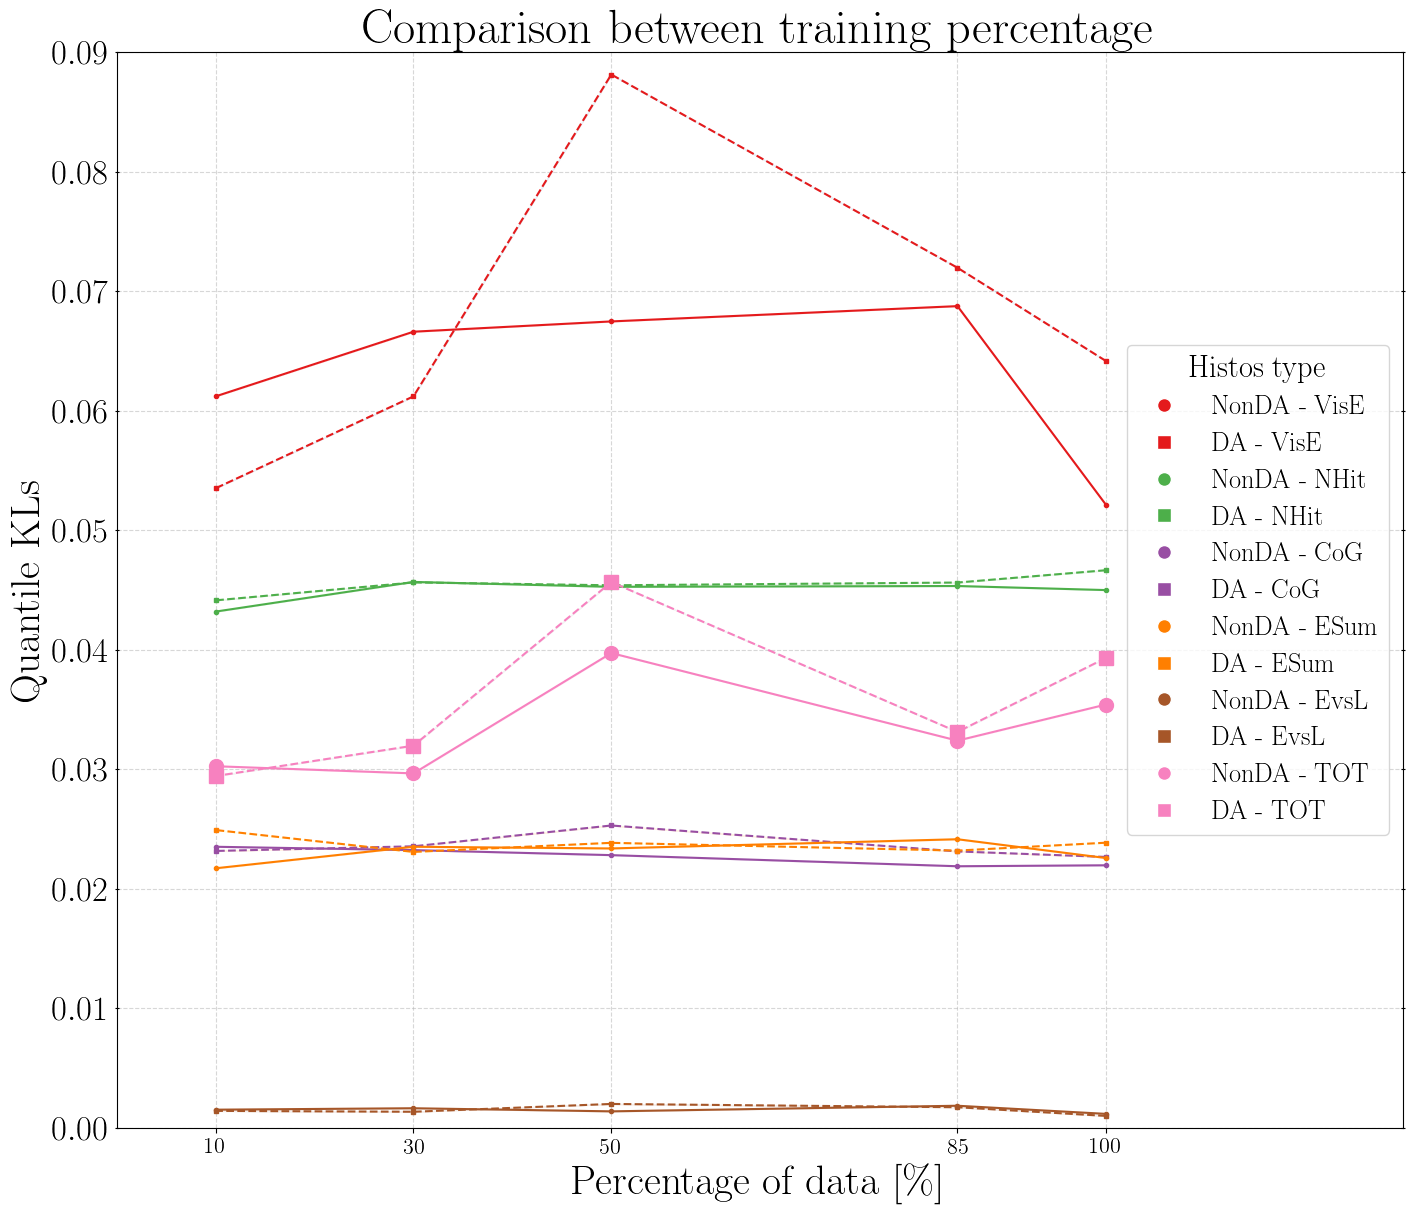

In [263]:
# AVERAGE KL DIVERGENCE
data_dict = {                        # 100%    85%      50%     30%    10%      
    'NonDA - VisE ':   {'mean':    [0.05213, 0.06874, 0.06746, 0.06660, 0.06119], 
                        'std_dev': [0, 0, 0, 0, 0]},
    'DA  - VisE'  :    {'mean':    [0.064153, 0.07195, 0.08812, 0.06119, 0.0535],
                        'std_dev': [0, 0, 0, 0, 0]},
    
    'NonDA - NHit ':   {'mean':    [0.04498, 0.04532, 0.045251, 0.045661, 0.04318], 
                        'std_dev': [0, 0, 0, 0, 0]},
    'DA  - NHit'  :    {'mean':    [0.04664, 0.04561, 0.04538, 0.045621, 0.04412],
                        'std_dev': [0, 0, 0, 0, 0]},

    'NonDA - CoG ':    {'mean':    [0.02195, 0.02187, 0.02280, 0.02322, 0.0235], 
                        'std_dev': [0, 0, 0, 0, 0]},
    'DA - CoG'  :      {'mean':    [0.02265, 0.023112, 0.02528, 0.02354, 0.02315],
                        'std_dev': [0, 0, 0, 0, 0]},

    'NonDA - ESum ':   {'mean':    [0.02256, 0.02413, 0.02336, 0.02350, 0.0217], 
                        'std_dev': [0, 0, 0, 0, 0]},
    'DA  - ESum'  :    {'mean':    [0.02384, 0.02318, 0.02383, 0.023069, 0.0249],
                        'std_dev': [0, 0, 0, 0, 0]},

    'NonDA - EvsL ':   {'mean':    [0.00115, 0.00183, 0.00136, 0.00162, 0.0015], 
                        'std_dev': [0, 0, 0, 0, 0]},
    'DA  - EvsL'  :    {'mean':    [0.00098, 0.001705, 0.00198, 0.001326, 0.0014],
                        'std_dev': [0, 0, 0, 0, 0]},

    'NonDA - TOT':   {'mean':    [0.0354, 0.03238, 0.03971, 0.02964, 0.03024], 
                        'std_dev': [0, 0, 0, 0, 0]},
    'DA - TOT'  :    {'mean':    [0.0393, 0.03311, 0.04565, 0.03196, 0.02942],
                        'std_dev': [0, 0, 0, 0, 0]},
                        
}

plot_comparison(data_dict, ytitle='Quantile KLs', crange= (0.1, .9), yrange=(0, 0.09))

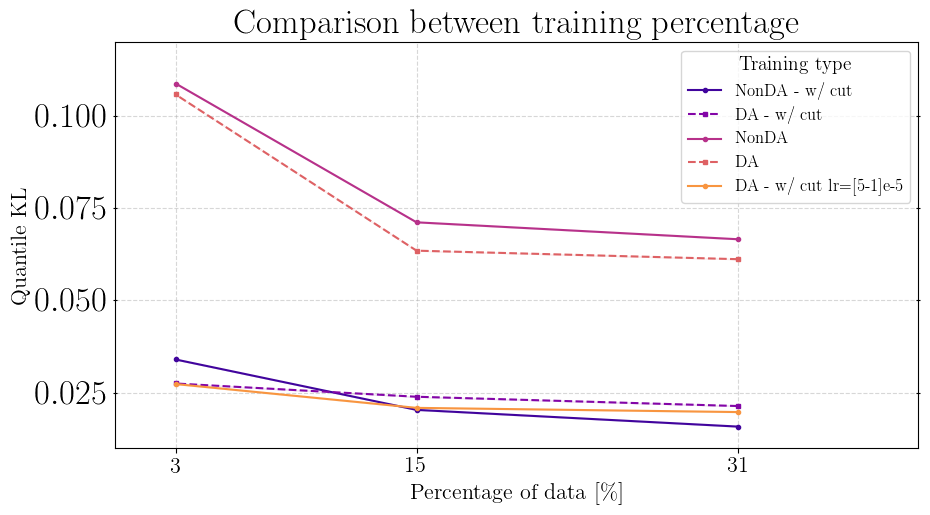

In [3]:
# AVERAGE KL DIVERGENCE
data_dict = {                        # 30%    15%        3%   
    'NonDA - w/ cut ':   {'mean':    [ 0.015785, 0.020317,  0.033982, ],
                        'std_dev': [0, 0, 0]},    
    'DA - w/ cut '  :    {'mean':    [ 0.021360, 0.023878,  0.027473],
                        'std_dev': [0, 0, 0,]},
    
    'NonDA ':   {'mean':    [ 0.06660, 0.07119, 0.10884 ], 
                        'std_dev': [0, 0, 0]},
    'DA'  :    {'mean':    [ 0.06119, 0.0635, 0.10586],
                        'std_dev': [0, 0, 0]},
    'DA - w/ cut lr=[5-1]e-5 '  :    {'mean':    [ 0.019722, 0.020862,  0.027321],
                        'std_dev': [0, 0, 0,]},

    
                        
}

plot_comparison(data_dict, ytitle='Quantile KL', crange= (0.1, .75), yrange=(0.010, 0.12 ))

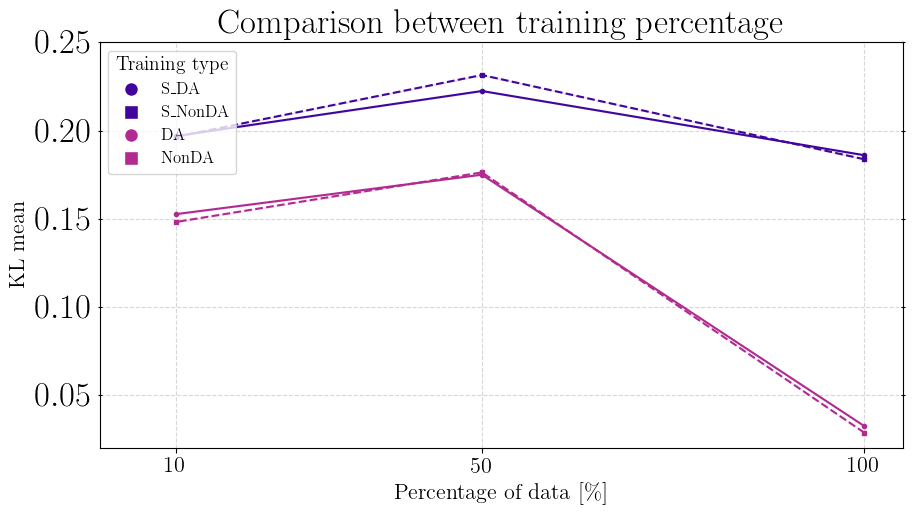

In [46]:
# AVERAGE KL DIVERGENCE
data_dict = {                      # 100%     50%             10%                
    'S_DA':         {'mean':    [0.185996, 0.222407, 0.196876, ],
                'std_dev': [0, 0, 0]},    
    'S_NonDA'  :    {'mean':    [0.18369, 0.231486, 0.196446, ],
                'std_dev': [0, 0, 0]},
    
    'DA'  :    {'mean':    [0.032375, 0.174949, 0.152584, ],
                'std_dev': [0, 0, 0]},        
    'NonDA'  :    {'mean':    [0.028627, 0.176274, 0.148141, ],
                'std_dev': [0, 0, 0]},             

}

plot_comparison(data_dict, ytitle='KL mean', crange= (.1, 1), yrange=(0.02, .25))

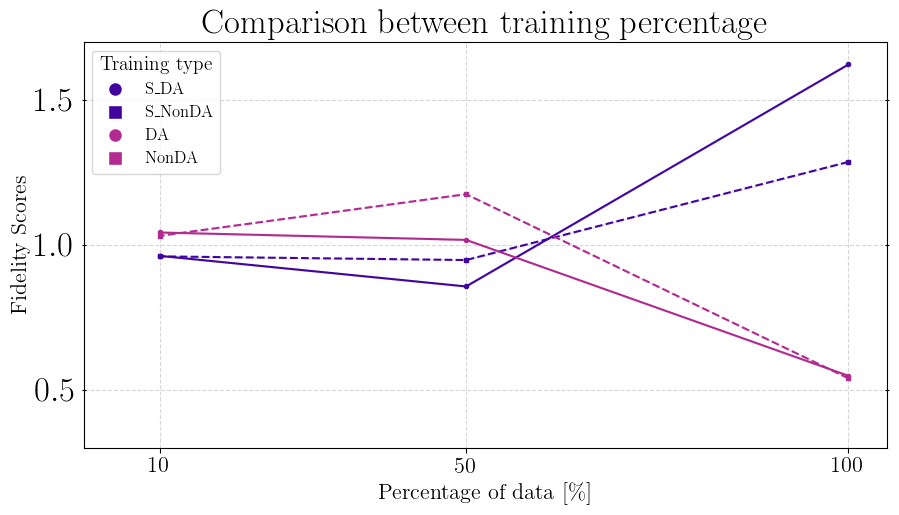

In [47]:
# AVERAGE KL DIVERGENCE
data_dict = {                      # 100%     50%             10%                
    'S_DA':         {'mean':    [1.62370279306378, 0.857367, 0.962856, ],
                'std_dev': [0, 0, 0]},    
    'S_NonDA'  :    {'mean':    [1.28731116761534, 0.94859, 0.961192, ],
                'std_dev': [0, 0, 0]},
    
    'DA'  :    {'mean':    [0.548916651853412, 1.018129, 1.043624, ],
                'std_dev': [0, 0, 0]},        
    'NonDA'  :    {'mean':    [0.540069387467469,1.175914, 1.032328, ],
                'std_dev': [0, 0, 0]},             

}

plot_comparison(data_dict, ytitle='Fidelity Scores', crange= (.1, 1), yrange=(0.3, 1.7))

In [240]:
# Creating a DataFrame from the dictionary
df = pd.DataFrame(data_dict)

# Apply style to add border between rows
# styled_df = df.style.set_table_styles([{'selector': 'tr', 'props': [('border', '1px solid black')]}])

df

,NonDA - VisE,DA - VisE,NonDA - NHit,DA - NHit,NonDA - CoG,DA - CoG,NonDA - ESum,DA - ESum,NonDA - EvsL,DA - EvsL,NonDA - TOT,DA - TOT
mean,"[0.05213, 0.06874, 0.06746, 0.0666, 0.06119]","[0.064153, 0.07195, 0.08812, 0.06119, 0.0535]","[0.04498, 0.04532, 0.045251, 0.045661, 0.04318]","[0.04664, 0.04561, 0.04538, 0.045621, 0.04412]","[0.02195, 0.02187, 0.0228, 0.02322, 0.0235]","[0.02265, 0.023112, 0.02528, 0.02354, 0.02315]","[0.02256, 0.02413, 0.02336, 0.0235, 0.0217]","[0.02384, 0.02318, 0.02383, 0.023069, 0.0249]","[0.00115, 0.00183, 0.00136, 0.00162, 0.0015]","[0.00098, 0.001705, 0.00198, 0.001326, 0.0014]","[0.0354, 0.03238, 0.03971, 0.02964, 0.03024]","[0.0393, 0.03311, 0.04565, 0.03196, 0.02942]"
std_dev,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]"
